In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join, basename

import numpy as np
import matplotlib.pyplot as plt
from h5py import File
import seaborn as sns
from scipy.stats import norm
import scienceplots

import candel
from candel import plot_corner_from_hdf5
from utils import * 


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
config = candel.load_config(config_path, )


root = join(config["root_main"], "results", "S8_paper")
print(f"root: {root}")

root: /Users/rstiskalek/Projects/CANDEL/results/S8_paper


In [3]:
!ls /Users/rstiskalek/Projects/CANDEL/results/S8_paper/precomputed_los*.hdf5

/Users/rstiskalek/Projects/CANDEL/results/S8_paper/precomputed_los_Carrick2015_2MTF_noMNR.hdf5
/Users/rstiskalek/Projects/CANDEL/results/S8_paper/precomputed_los_Carrick2015_CF4_W1_MNR.hdf5
/Users/rstiskalek/Projects/CANDEL/results/S8_paper/precomputed_los_Carrick2015_PantheonPlus_MNR_Mdip_prior.hdf5
/Users/rstiskalek/Projects/CANDEL/results/S8_paper/precomputed_los_Carrick2015_SFI_MNR.hdf5


## Posterior summary

In [4]:
fname = "/Users/rstiskalek/Projects/CANDEL/results/S8_paper/precomputed_los_Carrick2015_CF4_W1_MNR.hdf5"

with File(fname, "r") as f:
    grp = f["samples"]
    print(f"keys: {list(grp.keys())}")

    samples = {key: grp[key][...] for key in grp.keys()}


keys_read = ["b1", "beta"]
# keys_read = ['M_dipole_b', 'M_dipole_ell', 'M_dipole_mag']
# keys_read = ['Vext_b', 'Vext_ell', 'Vext_mag']

for key in keys_read:
    low, med, high = np.percentile(samples[key], [16, 50, 84])
    low = med - low
    high = high - med
    print(f"{key}: {med:.3f} +{high:.3f} -{low:.3f}")


# a_TFR_dipole_mag: 0.073 +0.024 -0.026

keys: ['Vext', 'Vext_b', 'Vext_ell', 'Vext_mag', 'a_TFR', 'b1', 'b_TFR', 'beta', 'c_TFR', 'eta_latent', 'eta_prior_mean', 'eta_prior_std', 'mag_latent', 'sigma_mu', 'sigma_v']
b1: 1.377 +0.018 -0.020
beta: 0.456 +0.018 -0.018


### Playground

precomputed_los_Carrick2015_CF4_W1_MNR.hdf5: Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, eta_latent, eta_prior_mean, eta_prior_std, mag_latent, sigma_mu, sigma_v
precomputed_los_Carrick2015_SFI_MNR.hdf5: Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, eta_latent, eta_prior_mean, eta_prior_std, mag_latent, sigma_mu, sigma_v
precomputed_los_Carrick2015_2MTF_noMNR.hdf5: Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, sigma_mu, sigma_v
precomputed_los_Carrick2015_PantheonPlus_MNR_Mdip_prior.hdf5: M, M_dipole_b, M_dipole_ell, M_dipole_mag, Vext, Vext_b, Vext_ell, Vext_mag, b1, beta, mag_latent, sigma_mu, sigma_v
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


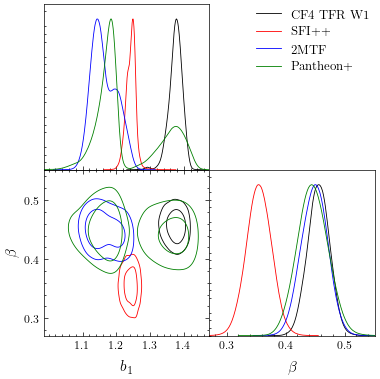

In [5]:
fnames = [
    "precomputed_los_Carrick2015_CF4_W1_MNR.hdf5",
    "precomputed_los_Carrick2015_SFI_MNR.hdf5",
    "precomputed_los_Carrick2015_2MTF_noMNR.hdf5",
    "precomputed_los_Carrick2015_PantheonPlus_MNR_Mdip_prior.hdf5"
    ]

labels = [
    "CF4 TFR W1",
    "SFI++",
    "2MTF",
    "Pantheon+"
    ]

fnames = [join(root, f) for f in fnames]

plot_corner_from_hdf5(
    fnames,
    labels=labels,
    # fontsize=18,
    filled=False,
    keys=["b1", "beta"],
    # filename="C15_full_posterior.pdf",
    )

In [22]:
beta2cosmo = candel.cosmo.Beta2Cosmology()

filenames = [
    "precomputed_los_Carrick2015_CF4_W1_MNR.hdf5",
    # "precomputed_los_Carrick2015_SFI_MNR.hdf5",
    "precomputed_los_Carrick2015_2MTF_noMNR.hdf5",
    "precomputed_los_Carrick2015_PantheonPlus_MNR_Mdip_prior.hdf5"
]

labels = [
    "CF4 TFR W1",
    # "SFI++",
    "2MTF",
    "Pantheon+"
    ]

fnames = [join(root, f) for f in filenames]
S8_list = compute_S8_all(fnames, beta2cosmo)

Building SR interpolator: 100%|██████████| 100/100 [00:00<00:00, 137.53it/s]


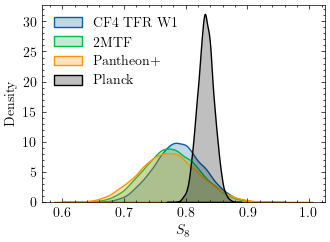

In [23]:
with plt.style.context("science"):
    plt.figure()

    # Plot KDEs for datasets
    for S8, label in zip(S8_list, labels):
        sns.kdeplot(S8, label=label, fill=True, )

    # KDE for Planck
    planck_mean, planck_std = 0.832, 0.013
    rng = np.random.default_rng(seed=42)
    planck_samples = rng.normal(loc=planck_mean, scale=planck_std, size=10_000)
    sns.kdeplot(planck_samples, label="Planck", fill=True, color="k", )

    plt.xlabel(r"$S_8$")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig("S8_posterior.png", bbox_inches="tight")
    plt.show()

In [ ]:
# cols = sns.color_palette()

# # Example data: Replace these with your actual data
# names = ["Joint", r"CF4 TFR $W1$-band", r"CF4 TFR $i$-band", "2MTF"]
# xs = [beta_joint, beta_CF4_TFR_w1, beta_CF4_TFR_i, beta_2MTF]
# colors = [cols[0]] * 4
# mean = [np.mean(x) for x in xs]
# lower = [np.percentile(x, 16) for x in xs]
# upper = [np.percentile(x, 84) for x in xs]

# # Additional datasets (mean and uncertainties)
# additional_names = [r"Carrick+2015", r"Boruah+2019", r"Said+2020", r"Boubel+24 $W1$-band", r"Boubel+24 $i$-band", ]
# additional_means = [0.431, 0.428, 0.341, 0.36, 0.33]
# additional_errs = [0.021, 0.012, 0.024, 0.02, 0.03, ]
# colors += [cols[4], cols[5], cols[6], cols[7], cols[7]]

# # Append the additional data to the main lists
# names.extend(additional_names)
# mean.extend(additional_means)
# lower.extend([m - e for m, e in zip(additional_means, additional_errs)])
# upper.extend([m + e for m, e in zip(additional_means, additional_errs)])

# # Calculate the asymmetric error bars
# y_err_lower = np.array(mean) - np.array(lower)
# y_err_upper = np.array(upper) - np.array(mean)

# with plt.style.context("science"):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     for spine_name, spine in ax.spines.items():
#         col_spine = spine.get_edgecolor()
#         lw_spine = spine.get_linewidth()

#     # Add a shaded region to highlight "This work"
#     # plt.axhspan(0.5, 4.5, color=cols[0], alpha=0.15)  # Flip shaded region to the y-axis

#     plt.axhline(4.5, color=col_spine, linestyle="dashed", lw=lw_spine)

#     # Plot each point with horizontal error bars
#     for i, (name, mu, err_lower, err_upper) in enumerate(zip(names, mean, y_err_lower, y_err_upper)):
#         color = colors[i]

#         # Plot the error bar
#         plt.errorbar(mu, i + 1, xerr=[[err_lower], [err_upper]],
#                      fmt="o", color=color, capsize=4, ms=3.5)

#         if i == 0:
#             plt.fill_betweenx([i + 0.5, i + 30], mu - err_lower, mu + err_upper, color=color, alpha=0.15)
#             # plt.axvline(mu - err_lower, color=color, linestyle="dotted")
#             # plt.axvline(mu + err_upper, color=color, linestyle="dotted")


#     # Customize y-axis and labels
#     plt.yticks(range(1, len(names) + 1), names, fontsize="small", minor=False)
#     plt.gca().tick_params(axis="y", which="both", length=0)
#     plt.xlabel(r"$\beta^* = f \sigma_{8, \mathrm{NL}} / \sigma_8^{\rm g}$")
#     plt.ylim(0.5, len(names) + 0.5)

#     plt.gca().invert_yaxis()
#     plt.gca().text(0.06, 0.96, "This work", color=col_spine,
#                    fontsize="small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.gca().text(0.06, 0.53, "Literature", color=col_spine,
#                    fontsize="small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.tight_layout()
#     plt.savefig("../../plots/C15_beta.pdf", dpi=450)
#     plt.show()

In [ ]:
# cols = sns.color_palette()

# # My data
# names = [r"Joint",]

# xs = [fsigma8_nonlinear_to_S8(compute_fsigma8_nonlinear(beta_joint, "carrick"), 0.3, which="sr"),
#       # fsigma8_nonlinear_to_S8(compute_fsigma8_nonlinear(beta_joint, "carrick"), 0.3, which="juszkiewicz"),
#       ]

# means = [np.mean(x) for x in xs]
# errs = [(np.percentile(x, 16), np.percentile(x, 84)) for x in xs]
# colors = [cols[0],]


# # Literature

# xs = [
#     ("Huterer+2017", 0.780, 0.087),
#     ("Nusser 2017", 0.776, 0.120),
#     ("Boruah+2019", 0.776, 0.033),
#     ("Said+2020", 0.637, 0.054),
#     ("DES Y3 + KiDS-1000", 0.790, (0.014, 0.018)),
#     ("DES Y3", 0.776, 0.017),
#     ("KIDS-1000", 0.766, (0.014, 0.020)),
#     ("DESI DR1", 0.836, 0.035),
#     ("DES Y3", 0.778, (0.031, 0.037)),
#     ("SPT-SZ", 0.739, 0.041),
#     ("Planck-SZ", 0.774, 0.034),
#     ("DES-Clusters", 0.65, 0.05),
#     ("Planck", 0.832, 0.013),
#       ]

# names += [x[0] for x in xs]
# means += [x[1] for x in xs]
# stds = [x[2] for x in xs]


# errs_new = []
# for m, s in zip(means[len(errs):], stds):
#     if isinstance(s, tuple):
#         lower = m - s[0]
#         upper = m + s[1]
#     else:
#         lower = m - s
#         upper = m + s
#     errs_new.append((lower, upper))

# errs += errs_new
# colors += [cols[1]] * 4 + [cols[2]] * 3 + [cols[3]] * 2 + [cols[4]] * 3 + [cols[5]]

# # Extract lower and upper error bounds
# lower = [m - e[0] for m, e in zip(means, errs)]
# upper = [e[1] - m for m, e in zip(means, errs)]

# # Plot
# with plt.style.context("science"):
#     fig = plt.figure(figsize=(3.5, 2.625 * 1.5))
#     ax = fig.add_subplot(111)
#     for spine_name, spine in ax.spines.items():
#         col_spine = spine.get_edgecolor()
#         lw_spine = spine.get_linewidth()

#     # Add a shaded region to highlight "This work"
#     alpha = 0.15
#     plt.axhline(1.5, color=col_spine, linestyle="dashed", lw=lw_spine)
#     plt.gca().text(0.97, 0.98, "This work", color=col_spine,
#                    fontsize="x-small", ha="right", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.axhline(5.5, color=col_spine, linestyle="dashed", lw=lw_spine)
#     plt.gca().text(0.03, 0.92, "Peculiar\nvelocity\n(literature)", color=col_spine,
#                    fontsize="x-small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.axhline(8.5, color=col_spine, linestyle="dashed", lw=lw_spine)
#     plt.gca().text(0.03, 0.63, "Weak lensing", color=col_spine,
#                    fontsize="x-small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.axhline(10.5, color=col_spine, linestyle="dashed", lw=lw_spine)
#     plt.gca().text(0.03, 0.42, "Clustering", color=col_spine,
#                    fontsize="x-small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.axhline(13.5, color=col_spine, linestyle="dashed", lw=lw_spine)

#     plt.gca().text(0.03, 0.27, "Cluster\nabundance", color=col_spine,
#                    fontsize="x-small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     plt.gca().text(0.03, 0.055, "CMB", color=col_spine,
#                    fontsize="x-small", ha="left", va="top", weight="bold",
#                    transform=plt.gca().transAxes)

#     # Plot each point with horizontal error bars
#     for i, (name, mu, err_lower, err_upper) in enumerate(zip(names, means, lower, upper)):
#         color = colors[i]

#         plt.errorbar(mu, i + 1, xerr=[[err_lower], [err_upper]],
#                      fmt="o", color=color, capsize=4, ms=3.5)

#         if i == 0:
#             plt.fill_betweenx([i + 0.5, i + 30], mu - err_lower, mu + err_upper, color=color, alpha=0.15)

#     # Customize y-axis and labels
#     plt.yticks(range(1, len(names) + 1), names, fontsize="small", minor=False)
#     plt.gca().tick_params(axis="y", which="both", length=0)
#     plt.xlabel(r"$S_8$")
#     plt.ylim(0.5, len(names) + 0.5)

#     # Reverse y-axis
#     plt.gca().invert_yaxis()

#     plt.tight_layout()
#     plt.savefig("../../plots/S8_comparison.pdf", dpi=450)
#     plt.show()

In [ ]:
	
# import posterior_agreement



# xnew = beta_joint# * np.random.normal(1., 0.05, size=len(beta_joint))

# S8_ours = fsigma8_nonlinear_to_S8(compute_fsigma8_nonlinear(xnew, "carrick"), 0.3, which="sr")

# print(np.mean(S8_ours), np.std(S8_ours))

# # ("Boruah+2019", 0.776, 0.033)
# # 0.790, (0.014, 0.018)
# d = norm(0.832, 0.013)
# x = d.rvs(len(S8_ours))

# agreement_1d = posterior_agreement.compute_agreement((S8_ours, x))
# print("p-value %.3f, corresponding to %.1f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))